
<h1 align = center>Stock Market Prediction And Forecasting Using Stacked LSTM</h1>

In [1]:
import pandas_datareader as pdr 
import pandas as pd
import numpy as np

Taking  Apple company stock prices of past 7 months

so using tiingo site api key to call data

In [2]:
#data scollection
key= "66b4c977fce1445730b09491153338ec69b3fb92"
df= pdr.get_iex_data_tiingo('AAPL',api_key=key) #key resets every hour
df


close     high      low     open
symbol date                                                        
AAPL   2020-12-08 17:15:00+00:00  124.02  124.085  123.890  124.040
       2020-12-08 17:20:00+00:00  124.01  124.070  123.940  124.025
       2020-12-08 17:25:00+00:00  124.07  124.105  123.980  124.015
       2020-12-08 17:30:00+00:00  124.14  124.170  124.020  124.055
       2020-12-08 17:35:00+00:00  124.32  124.320  124.090  124.145
...                                  ...      ...      ...      ...
       2021-06-02 19:40:00+00:00  124.88  124.900  124.775  124.795
       2021-06-02 19:45:00+00:00  124.96  124.980  124.870  124.885
       2021-06-02 19:50:00+00:00  125.07  125.160  124.975  124.975
       2021-06-02 19:55:00+00:00  125.08  125.135  124.975  125.070
       2021-06-02 20:00:00+00:00  125.08  125.080  125.080  125.080

[10000 rows x 4 columns]

In [3]:
df.to_csv('AAPL.csv')

In [4]:
df=pd.read_csv("AAPL.csv")

In [5]:
df.head()

,symbol,date,close,high,low,open
0,AAPL,2020-12-08 17:15:00+00:00,124.02,124.085,123.89,124.040
1,AAPL,2020-12-08 17:20:00+00:00,124.01,124.070,123.94,124.025
2,AAPL,2020-12-08 17:25:00+00:00,124.07,124.105,123.98,124.015
3,AAPL,2020-12-08 17:30:00+00:00,124.14,124.170,124.02,124.055
4,AAPL,2020-12-08 17:35:00+00:00,124.32,124.320,124.09,124.145


In [6]:
df1=df.reset_index()['close']
df1

0       124.02
1       124.01
2       124.07
3       124.14
4       124.32
         ...  
9995    124.88
9996    124.96
9997    125.07
9998    125.08
9999    125.08
Name: close, Length: 10000, dtype: float64

In [7]:
df1.shape

(10000,)

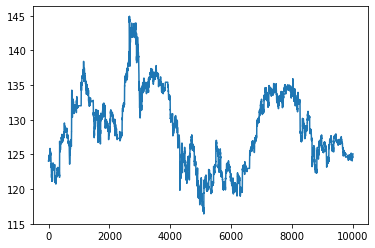

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

LSTM are sensitive to the scale, so we will scale it using min max scaler and scale it b/w  0 to 1

In [9]:
from sklearn.preprocessing import  MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

train test splitting on time series data is different we cant use random seed method or cv method. We divide by days coz next day data may be dependent on previous day 

In [10]:
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1] 

In [11]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:]

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [13]:
import numpy
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:

X_train.shape, y_train.shape

((6399, 100), (6399,))

In [15]:
print(X_test.shape), print(ytest.shape)

(3399, 100)
(3399,)


(None, None)

In [16]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [17]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
model=Sequential([
LSTM(50,return_sequences=True,input_shape=(100,1)),
LSTM(50,return_sequences=True),
LSTM(50),
Dense(1),
])
model.compile(loss='mean_squared_error',optimizer='adam'
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
100/100 [==============================] - 7s 26ms/step - loss: 0.0066 - val_loss: 4.2551e-04
Epoch 2/100
100/100 [==============================] - 2s 16ms/step - loss: 7.6778e-04 - val_loss: 3.7894e-04
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 7.1986e-04 - val_loss: 3.4991e-04
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 6.4538e-04 - val_loss: 3.0799e-04
Epoch 5/100
100/100 [==============================] - 2s 16ms/step - loss: 5.8338e-04 - val_loss: 3.8458e-04
Epoch 6/100
100/100 [==============================] - 2s 16ms/step - loss: 5.5615e-04 - val_loss: 2.5443e-04
Epoch 7/100
100/100 [==============================] - 2s 16ms/step - loss: 4.8545e-04 - val_loss: 2.4643e-04
Epoch 8/100
100/100 [==============================] - 2s 16ms/step - loss: 4.6099e-04 - val_loss: 2.9733e-04
Epoch 9/100
100/100 [==============================] - 2s 16ms/step - loss: 3.8833e-04 - val_loss: 2.0414e-04
Epoch 10/100
1

In [21]:
### Lets Do the prediction and check performance metrics
test_predict=model.predict(X_test)

In [22]:
##Transformback to original form
test_predict=scaler.inverse_transform(test_predict)

In [23]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(ytest,test_predict))

128.8100216377853